In [24]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [38]:
I_1, I_w, m_1, m_w, r, l, T_w, g, T_2, M = sp.symbols('I_1, I_w, m_1, m_w, r, l, T_w, g, T_2')
theta_1, theta_w = dynamicsymbols('theta_1, theta_w')

theta_wd = theta_w.diff()
theta_wdd = theta_wd.diff()
theta_1d = theta_1.diff()
theta_1dd = theta_1d.diff()

q = sp.Matrix([[theta_w], [theta_1]])
qd = q.diff()
qdd = qd.diff()

u = sp.Matrix([T_w])

tau = sp.Matrix([[((m_w+m_1)*r**2 + I_w)*theta_wdd + m_1*r*l*theta_1dd*sp.cos(theta_1) - m_1*r*l*theta_1d**2 * sp.sin(theta_1) - T_2 - T_w],
                 [(I_1 + m_1*l**2)*theta_1dd + m_1*r*l*sp.cos(theta_1)*theta_wdd - m_1*g*l*sp.sin(theta_1) - T_2 + T_w]])

In [39]:
tau

Matrix([
[-T_2 - T_w - l*m_1*r*sin(theta_1(t))*Derivative(theta_1(t), t)**2 + l*m_1*r*cos(theta_1(t))*Derivative(theta_1(t), (t, 2)) + (I_w + r**2*(m_1 + m_w))*Derivative(theta_w(t), (t, 2))],
[                                     -T_2 + T_w - g*l*m_1*sin(theta_1(t)) + l*m_1*r*cos(theta_1(t))*Derivative(theta_w(t), (t, 2)) + (I_1 + l**2*m_1)*Derivative(theta_1(t), (t, 2))]])

In [40]:
zero_point = {f_d:0}
tau_sum = tau[0] + tau[1]
tau_sum = sp.simplify(tau_sum.subs(zero_point))
tau_sum

-2*T_2 - g*l*m_1*sin(theta_1(t)) - l*m_1*r*sin(theta_1(t))*Derivative(theta_1(t), t)**2 + l*m_1*r*cos(theta_1(t))*Derivative(theta_1(t), (t, 2)) + l*m_1*r*cos(theta_1(t))*Derivative(theta_w(t), (t, 2)) + (I_1 + l**2*m_1)*Derivative(theta_1(t), (t, 2)) + (I_w + r**2*(m_1 + m_w))*Derivative(theta_w(t), (t, 2))

In [41]:
eq_point = {sp.sin(theta_1):theta_1, sp.cos(theta_1):1, theta_1d**2:0}
tau_eq = sp.simplify(tau.subs(eq_point))
tau_eq

Matrix([
[             -T_2 - T_w + l*m_1*r*Derivative(theta_1(t), (t, 2)) + (I_w + r**2*(m_1 + m_w))*Derivative(theta_w(t), (t, 2))],
[-T_2 + T_w - g*l*m_1*theta_1(t) + l*m_1*r*Derivative(theta_w(t), (t, 2)) + (I_1 + l**2*m_1)*Derivative(theta_1(t), (t, 2))]])

In [42]:
Ml, Cl, Gl, Wl = get_EoM_from_T(tau_eq,qdd,g,u)
Cl

Matrix([
[-T_2],
[-T_2]])

In [43]:
Ml

Matrix([
[I_w + r**2*(m_1 + m_w),        l*m_1*r],
[               l*m_1*r, I_1 + l**2*m_1]])

In [44]:
Gl

Matrix([
[                  0],
[-g*l*m_1*theta_1(t)]])

In [68]:
Wl

Matrix([
[ 1],
[-1]])

In [45]:
linearlize_eq = {sp.sin(theta_1):theta_1, sp.cos(theta_1):1, theta_1.diff()**2:0}
tau_linear = tau_eq.subs(linearlize_eq)
tau_linear

Matrix([
[             -T_2 - T_w + l*m_1*r*Derivative(theta_1(t), (t, 2)) + (I_w + r**2*(m_1 + m_w))*Derivative(theta_w(t), (t, 2))],
[-T_2 + T_w - g*l*m_1*theta_1(t) + l*m_1*r*Derivative(theta_w(t), (t, 2)) + (I_1 + l**2*m_1)*Derivative(theta_1(t), (t, 2))]])

In [47]:
param = {I_1: 0.007514491, I_w:0.004806909,  m_1:2.786,   m_w:2.292, r:0.069, l: 0.171,  g:9.81}

Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)

In [66]:
Mlp

Matrix([
[0.028983267, 0.032872014],
[0.032872014, 0.088979917]])

In [67]:
Clp

Matrix([
[-T_2],
[-T_2]])

In [48]:
Mlp_inv = Mlp.inv()
qdd_rhs_A = Mlp_inv*(-Clp -Glp)
qdd_rhs_B = Mlp_inv*Wlp*u

In [49]:
X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u

In [54]:
X

Matrix([
[               theta_w(t)],
[               theta_1(t)],
[Derivative(theta_w(t), t)],
[Derivative(theta_1(t), t)]])

In [53]:
Xd_A

Matrix([
[                         Derivative(theta_w(t), t)],
[                         Derivative(theta_1(t), t)],
[37.4462251600723*T_2 - 102.531320317116*theta_1(t)],
[-2.59533662757911*T_2 + 90.401903351997*theta_1(t)]])

In [55]:
A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)

In [56]:
A

Matrix([
[0,                 0, 1, 0],
[0,                 0, 0, 1],
[0, -102.531320317116, 0, 0],
[0,   90.401903351997, 0, 0]])

In [57]:
B

Matrix([
[                0],
[                0],
[ 81.3235676338785],
[-41.2820058462271]])

In [58]:
ss0 = [A, B, C, D]
sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
mprint(sys0)

A = [[   0.            0.            1.            0.        ]
     [   0.            0.            0.            1.        ]
     [   0.         -102.53132032    0.            0.        ]
     [   0.           90.40190335    0.            0.        ]]

B = [[  0.        ]
     [  0.        ]
     [ 81.32356763]
     [-41.28200585]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



In [19]:
matrix_rank(control.obsv(A,C))

4

In [20]:
matrix_rank(control.ctrb(A,C))

4

In [18]:
sys0_output = sys0[2,0]
mprint(sys0_output)
tf_20 = tf_clean(control.minreal(control.ss2tf(sys0_output)))
tf_20

A = [[   0.            0.            1.            0.        ]
     [   0.            0.            0.            1.        ]
     [   0.         -435.01156202    0.            0.        ]
     [   0.           46.34116633    0.            0.        ]]

B = [[ 0.        ]
     [ 0.        ]
     [35.73360799]
     [-2.93867428]]

C = [[0. 0. 1. 0.]]

D = [[0.]]

0 states have been removed from the model


TransferFunction(array([  35.73360799,    0.        , -377.57978179]), array([  1.        ,   0.        , -46.34116633,   0.        ]))

In [11]:
eig(np.array(A, dtype=float))

(array([ 0.       ,  0.       ,  4.2050835, -4.2050835]),
 array([[ 1.00000000e+000, -1.00000000e+000, -2.29712214e-001,
          2.29712214e-001],
        [ 0.00000000e+000,  0.00000000e+000,  2.75258921e-002,
         -2.75258921e-002],
        [ 0.00000000e+000,  4.00833672e-292, -9.65959041e-001,
         -9.65959041e-001],
        [ 0.00000000e+000,  0.00000000e+000,  1.15748675e-001,
          1.15748675e-001]]))

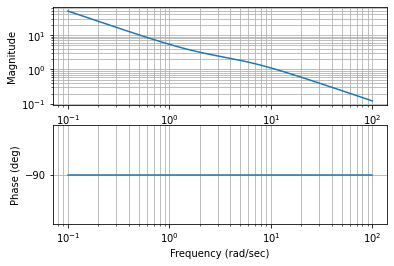

In [12]:
control.bode(tf_20);

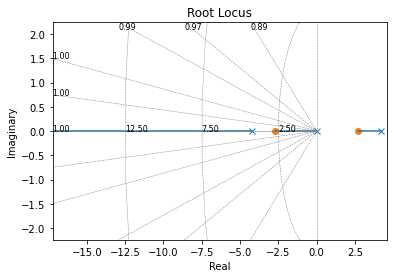

In [13]:
control.rlocus(tf_20);

In [14]:
mprint(sys0)

A = [[   0.            0.            1.            0.        ]
     [   0.            0.            0.            1.        ]
     [   0.         -147.56791173    0.            0.        ]
     [   0.           17.68272722    0.            0.        ]]

B = [[ 0.        ]
     [ 0.        ]
     [12.19453303]
     [-0.86036235]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]



In [65]:
Q = sp.Matrix([ [15,0,0,0],
                [0,15,0,0],
                [0,0,1,0],
                [0,0,0,1]])
R = sp.Matrix([ [0.01] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)

print(K)


sysc = sys0.feedback(K)


[[ -38.72983346 -417.2600717   -22.92438897  -67.62302196]]


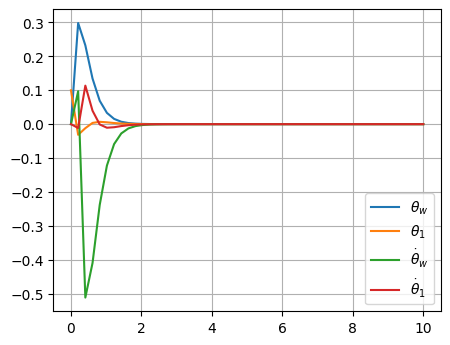

In [60]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

x0 = [0, 0.1, 0, 0]
u = 0
dt = 0.1
tf = 10

t, y = control.forced_response(sysc, X0=x0, T=pl.linspace(0,tf), transpose=True)


plt.figure(1, figsize=(5,4), dpi=100)
plt.plot(t, y);
plt.legend([r'$\theta_w$',r'$\theta_1$',r'$\dot\theta_w$',r'$\dot\theta_1$'], loc='best')
plt.grid()

In [49]:
K @ x0

array([-13.1184506])

In [61]:
# Rough 한 조건식
vmax_ = 22/3.6
t_ = 20 #sec

target_pos = vmax_*t_
v = vmax_/target_pos
a = v/4
a

0.0125

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.98692810e-04,  1.79738562e-01,  1.79738562e+01],
       [ 3.59477124e-03,  3.59477124e-01,  1.79738562e+01],
       ...,
       [ 1.43790490e+03,  3.59477124e-01, -1.79738562e+01],
       [ 1.43790760e+03,  1.79738562e-01, -1.79738562e+01],
       [ 1.43790760e+03,  1.79738562e-01, -1.79738562e+01]])

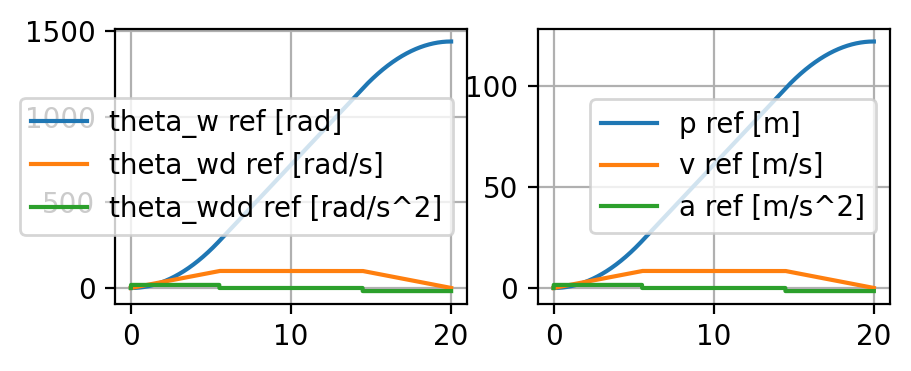

In [62]:
t_s, traj_s = Trapezoidal_Traj_Gen_Given_Amax_and_T(a,t_,0.01)
theta_w_traj = traj_s/ 0.085

rad2deg = 180/np.pi
pl.figure(1, figsize=(5,4), dpi=200)

pl.subplot(221);
pl.plot(t_s, theta_w_traj*target_pos)
pl.legend(['theta_w ref [rad]', 'theta_wd ref [rad/s]', 'theta_wdd ref [rad/s^2]'], loc='best')
pl.grid()

pl.subplot(222);
pl.plot(t_s, traj_s*target_pos)
pl.legend(['p ref [m]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

theta_w_traj*target_pos
# print('Vmax :', max(traj_s[:,1])*target_pos*3.6, 'km/r and Amax:', max(traj_s[:,2])*target_pos/9.81, 'g')

In [63]:
theta_w_des = theta_w_traj[:,0]*target_pos
theta_wdot_des = theta_w_traj[:,1]*target_pos
zeros = np.zeros(len(traj_s))
theta_wdes = theta_w_des
theta_wdes = np.vstack((theta_wdes, zeros)) 
theta_wdes = np.vstack((theta_wdes, theta_wdot_des))
theta_wdes = np.vstack((theta_wdes, zeros))

theta_wdes.shape, theta_wdes

((4, 2001),
 array([[0.00000000e+00, 8.98692810e-04, 3.59477124e-03, ...,
         1.43790490e+03, 1.43790760e+03, 1.43790760e+03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.79738562e-01, 3.59477124e-01, ...,
         3.59477124e-01, 1.79738562e-01, 1.79738562e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))

/home/shin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in matmul
/home/shin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in matmul
/home/shin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in matmul


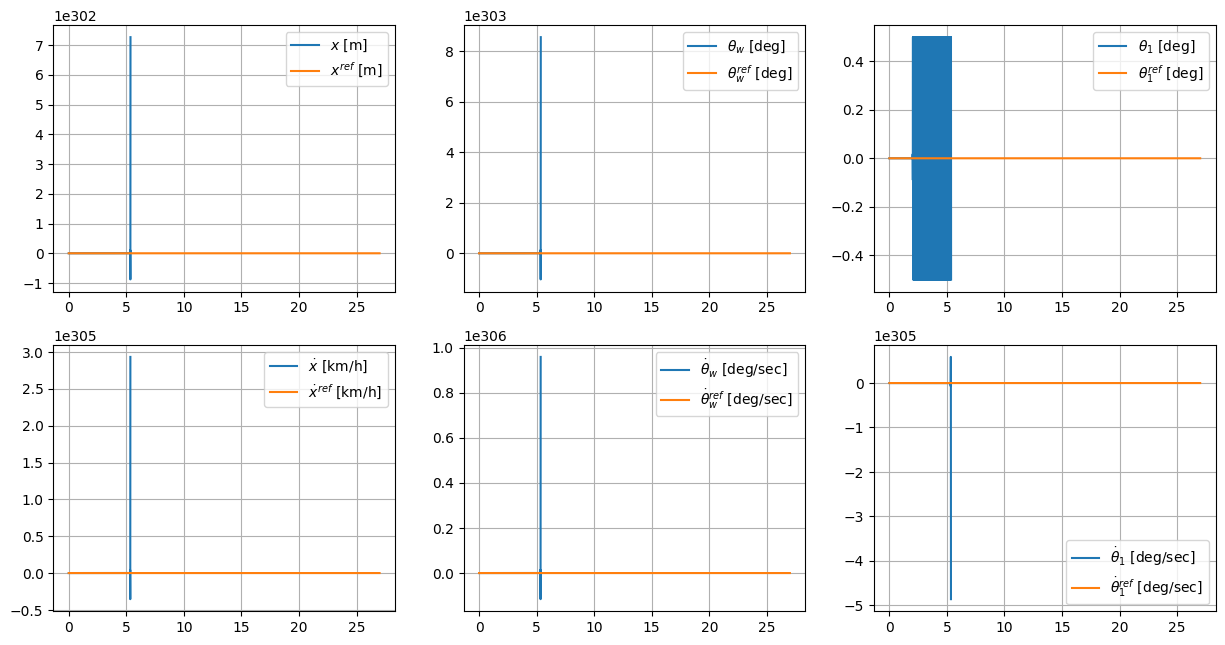

In [64]:
# Closed-loop Simulation
ss = sys0

rad2deg = 180/np.pi

def simulate_model_closed(X0, Xdes, K_gain, time_array, dt):
    Aop = ss.A
    Bop = ss.B
        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0])
    u_save = np.array([0])
    
    for i in range(len(time_array)):
        t = time_array[i]
         
        if t<2:
            Xref = X0       
        elif t>=2 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[1] = 0 # force to set xl_des as 0
            Xref = Xdes_final
        #print(t,j)
        # full-state feedback
        #u = K@(Xgoal - X)

        # partial feedback
        u1 = K_gain[0][1:]@(Xref[1:] - X[1:])
        #u2 = K_gain[1][1:]@(Xref[1:] - X[1:])
        
        # Forward Dynamics
        #Xd_prev = Xd
        # Linear Model
        u = np.array([u1])
        Xd = Aop@X + Bop@u # Xd = [xd, x_ld, theta_1d, xdd, x_ldd, theta_1dd]
        # NonLinear Model
        #q_qd = {x:X[0], x_l:X[1], theta_1:X[2], x.diff():X[3], x_l.diff():X[4], theta_1.diff():X[5]}
        #q_qd[F] = u1
        #q_qd[F_l] = u2
        #qdd = msubs(qdd_rhs_A_nonL,q_qd) + msubs(qdd_rhs_B_nonL,q_qd)
        #Xd = np.array([X[3], X[4], X[5], float(qdd[0]), float(qdd[1]), float(qdd[2])])
        
        t_save = np.vstack((t_save, t))
        x_save = np.vstack((x_save, X))
        xref_save = np.vstack((xref_save, Xref))
        u_save = np.vstack((u_save, np.array([u1])))
        
        X = X + Xd*dt        
        i+=1
       
        #limit setting
        xl_limit = 0.5
        if  X[1] >= xl_limit:
            X[1] = xl_limit
        elif X[1] <= -xl_limit:
            X[1] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [x, theta_1, x_dot, theta_1_dot]
X0 = np.array([0,0,0,0])

tf = 20 + 7
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(X0, theta_wdes, K, t, dt)

pl.figure(1, figsize=(15,12), dpi=100)

pl.subplot(331);
pl.plot(t_sim, x_sim[:,0]*0.085, t_sim, xref_sim[:,0]*0.085);
pl.legend([r'$x$ [m]', r'$x^{ref}$ [m]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,0], t_sim, xref_sim[:,0]);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,1], t_sim, xref_sim[:,1]);
pl.legend([r'$\theta_1$ [deg]', r'$\theta_1^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,2]*0.085*3.6, t_sim, xref_sim[:,2]*0.085*3.6);
pl.legend([r'$\dotx$ [km/h]', r'$\dotx^{ref}$ [km/h]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,2], t_sim, xref_sim[:,2]);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,3], t_sim, xref_sim[:,3]);
pl.legend([r'$\dot\theta_1$ [deg/sec]', r'$\dot\theta_1^{ref}$ [deg/sec]'], loc='best')
pl.grid()

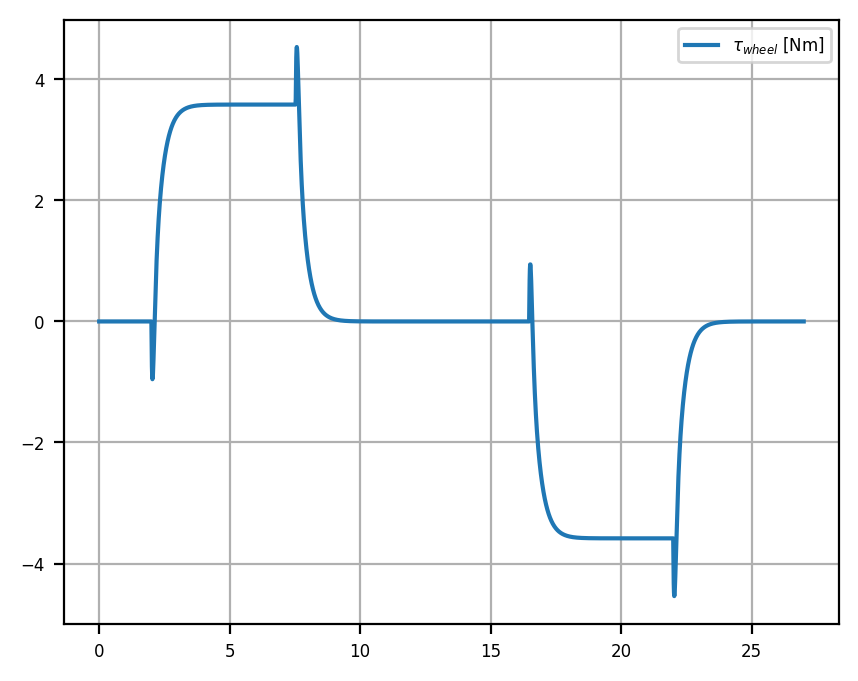

In [56]:
pl.figure(1, figsize=(5,4), dpi=200)
pl.plot(t_sim, u_sim);
pl.legend([r'$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()


In [57]:
# body size
param['body_width'] = 0.127 #0.5
param['body_height'] = 1.201442 #0.25

In [65]:
x_sim[:,3]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.84072105e-08, 7.59048075e-08, 7.34822699e-08])

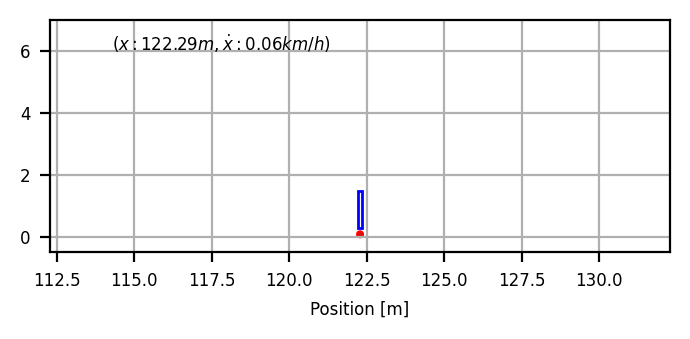

In [59]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure(3, figsize=(4,2), dpi=200)
ax = plt.axes()
plt.rcParams['font.size'] = '6'

data = x_sim

def draw_model(time):
    ax.cla()
    
    frame = time*10
    
    x = data[frame, 0]*0.085
    xdot = data[frame, 2] *0.085
    th_rad = data[frame,1]
    th_deg = -data[frame,1]*180/np.pi
    #print(x)
    radius = param[r]
    
    # configure
    x_wheel = x
    y_wheel = radius
       
    x_body = x + (param[l_cg] - param['body_height']/2)*np.sin(th_rad) - param['body_width']/2*np.cos(th_rad)
    y_body = radius + (param[l_cg] - param['body_height']/2)*np.cos(th_rad) + param['body_width']/2*np.sin(th_rad)
    
    # wheel
    ax.add_patch(
        patches.Circle((x_wheel, y_wheel), 
                       radius,
                       edgecolor = 'red',
                       facecolor = 'brown',
                       fill=True,))
    
    # body
    ax.add_patch(
        patches.Rectangle((x_body, y_body), 
                          param['body_width'], param['body_height'], th_deg,
                          edgecolor = 'blue',
                          facecolor = 'lightgray',
                          fill=False,))
    
    # data show up
    ax.text(x-8, 6, 
            r'$(x:{%s}m, \dotx:{%s}km/h)$' % (format(x,'.2f'), format(xdot*3.6,'.2f')))
    # ax.text(x-8, 5,        
    #         r'$(x_l:{%s}m, \theta_1:{%s}deg)$' % (format(-xl,'.2f'), format(-th_deg,'.2f')))
     
    ax.set_aspect('equal')
    ax.set_xlim([-10+x,10+x])
    ax.set_ylim([-0.5,7])
    ax.grid(axis='both')
    ax.set_xlabel('Position [m]', fontsize=6)

    time += 1 

anim = FuncAnimation(fig, draw_model, frames=int(len(t)/10), interval=100)
HTML(anim.to_html5_video())
anim.save("pitch_balancing.mp4",fps=20, dpi=200)
